In [1]:
'''
This is the best result we got from "multiple_experiments" notebook. However, RFE gave a better result in terms of MAE.
'''

'\nThis is the best result we got from "multiple_experiments" notebook. However, RFE gave a better result in terms of MAE.\n'

In [2]:
# import os
# import sys
# sys.path.insert(0, "../src/")
# import re
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# from handcrafted_features import DocBasedFeatureExtractor, Doc2VecChunkVectorizer, CorpusBasedFeatureExtractor
# from utils import get_doc_paths, read_labels
# 
# raw_docs_dir = "../data/raw_docs/"
# labels_dir = "../data/labels/"
# extracted_features_dir = "../data/extracted_features/"
# 
# lang = "eng"
# doc_paths = get_doc_paths(raw_docs_dir, lang)
# 
# sentences_per_chunk = 200
# d2vcv = Doc2VecChunkVectorizer(lang, sentences_per_chunk)
# d2vcv.fit_transform(doc_paths)


In [3]:
# all_chunk_based_features = []
# all_book_based_features = []
# all_average_sbert_sentence_embeddings = []
# all_doc2vec_chunk_embeddings = []
# for doc_path in tqdm(doc_paths):
#     fe = DocBasedFeatureExtractor(lang, doc_path, sentences_per_chunk)
#     chunk_based_features, book_based_features, average_sbert_sentence_embeddings, doc2vec_chunk_embeddings = fe.get_all_features()
#     all_chunk_based_features.extend(chunk_based_features)
#     all_book_based_features.append(book_based_features)
#     all_average_sbert_sentence_embeddings.append(average_sbert_sentence_embeddings)
#     all_doc2vec_chunk_embeddings.append(doc2vec_chunk_embeddings)


In [4]:
# cbfe = CorpusBasedFeatureExtractor(lang, doc_paths, all_average_sbert_sentence_embeddings, all_doc2vec_chunk_embeddings)
# all_corpus_based_features = cbfe.get_all_features()


In [5]:
# import os
# import pandas as pd
# 
# book_df = pd.DataFrame(all_book_based_features)
# book_df = book_df.merge(all_corpus_based_features, on="book_name")
# book_and_averaged_chunk_df = book_df.merge(pd.DataFrame(all_chunk_based_features).groupby("book_name").mean().reset_index(drop=False), on="book_name")
# 
# chunk_df = pd.DataFrame(all_chunk_based_features)
# chunk_and_copied_book_df = chunk_df.merge(pd.DataFrame(all_book_based_features), on="book_name")
# chunk_and_copied_book_df = chunk_and_copied_book_df.merge(all_corpus_based_features, on="book_name")
# 
# os.makedirs(f"{extracted_features_dir}/{lang}", exist_ok=True)
# book_df.to_csv(f"{extracted_features_dir}/{lang}/book_df.csv", index=False)
# book_and_averaged_chunk_df.to_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv", index=False)
# chunk_df.to_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv", index=False)
# chunk_and_copied_book_df.to_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv", index=False)


In [6]:
import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
labels_dir = "../data/labels/"
lang = "eng"

extreme_cases_df = pd.read_csv(labels_dir + "classified_data_step3_distance2_m3.csv", sep=",")[["file_name"]]

book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")


In [7]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from copy import deepcopy
from utils import read_labels
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
%matplotlib inline
import matplotlib.pyplot as plt

labels = read_labels(labels_dir)

class Experiment(object):
    def __init__(self, features, drop_columns_including, dimensionality_reduction, model, verbose):
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert model in ["xgboost", "svr", "lasso"]
        assert (dimensionality_reduction in ["ss_pca_0_95", "k_best_f_reg_0_10", "k_best_mutual_info_0_10"]) or (dimensionality_reduction is None)
        self.features = features
        self.labels = labels
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model = model
        self.verbose = verbose

        if features == "book":
            self.df = deepcopy(book_df)
        elif features == "chunk":
            self.df = deepcopy(chunk_df)
        elif features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
        self.df.loc[:, "y"] = self.df.book_name.apply(lambda x: self.labels[x]).tolist()

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self):
        # if any of these performs better than others, we can try to tune the hyperparameters
        # but I think for now it's more important to see which approach performs better
        # chunk based or doc based
        # use dimensionality reduction or not...
        if self.model == "xgboost":
            return XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.01, colsample_bytree=0.33, min_child_weight=6)
        elif self.model == "svr":
            return SVR()
        elif self.model == "lasso":
            return Lasso()
            
    def run(self):
        all_predictions = []
        all_labels = []
        train_mses = []
        train_maes = []
        validation_mses = []
        validation_maes = []
        validation_r2s = []

        df = self.df
        book_names = df['book_name'].unique()
        book_names_splitted = np.array_split(book_names, 10)
        for index, split in enumerate(book_names_splitted):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            print(validation_df.shape)
            validation_df = validation_df.merge(extreme_cases_df, how='inner', left_on="book_name", right_on="file_name").drop(columns=["file_name"])
            print(validation_df.shape)
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            if self.verbose:
                print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            if self.verbose:
                print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            model = self._get_model()
            model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            train_books["yhat"] = model.predict(train_X)
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

        mean_train_mse = np.mean(train_mses)
        mean_train_mae = np.mean(train_maes)
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        
        if self.verbose:
            print("------")
            print(f"Mean scores, TrainMSE: {np.round(mean_train_mse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}")

            plt.figure(figsize=(18, 6))
            plt.scatter(all_labels, all_predictions)
            plt.xlabel("Ground Truths")
            plt.ylabel("Predictions")

            plt.show();
        return mean_train_mse, mean_train_mae, mean_validation_mse, mean_validation_mae


Dropped 768 columns.
(60, 537)
(24, 537)
train_X.shape before ss_pca_0_95: (539, 535), validation_X.shape before ss_pca_0_95: (24, 535)
train_X.shape after ss_pca_0_95: (539, 164), validation_X.shape after ss_pca_0_95: (24, 164)
Fold: 1, TrainMSE: 0.009, TrainMAE: 0.085, ValMSE: 0.064, ValMAE: 0.227, ValR2: 0.437
(60, 537)
(27, 537)
train_X.shape before ss_pca_0_95: (539, 535), validation_X.shape before ss_pca_0_95: (27, 535)
train_X.shape after ss_pca_0_95: (539, 164), validation_X.shape after ss_pca_0_95: (27, 164)
Fold: 2, TrainMSE: 0.009, TrainMAE: 0.087, ValMSE: 0.073, ValMAE: 0.248, ValR2: 0.173
(60, 537)
(21, 537)
train_X.shape before ss_pca_0_95: (539, 535), validation_X.shape before ss_pca_0_95: (21, 535)
train_X.shape after ss_pca_0_95: (539, 164), validation_X.shape after ss_pca_0_95: (21, 164)
Fold: 3, TrainMSE: 0.009, TrainMAE: 0.087, ValMSE: 0.052, ValMAE: 0.188, ValR2: 0.373
(60, 537)
(23, 537)
train_X.shape before ss_pca_0_95: (539, 535), validation_X.shape before ss_pc

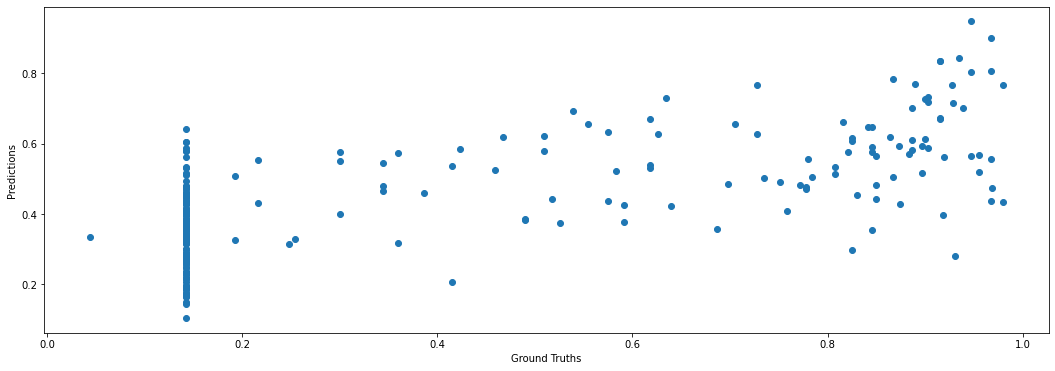

svr book_and_averaged_chunk ['average_sentence_embedding'] ss_pca_0_95 0.008599486504597069 0.08655909503739659 0.061125758222663126 0.21364444315639938


In [8]:
results = []

for model in ["svr"]:
    for features in ["book_and_averaged_chunk"]:
        for drop_columns_including in [["average_sentence_embedding"]]:
            for dimensionality_reduction in ["ss_pca_0_95"]:
                try:
                    experiment = Experiment(
                        features=features,
                        drop_columns_including=drop_columns_including,
                        dimensionality_reduction=dimensionality_reduction,
                        model=model,
                        verbose=True
                    )
                    train_mse, train_mae, validation_mse, validation_mae = experiment.run()
                    results.append((model, features, drop_columns_including, dimensionality_reduction, train_mse, train_mae, validation_mse, validation_mae))
                    print(model, features, drop_columns_including, dimensionality_reduction, train_mse, train_mae, validation_mse, validation_mae)
                except Exception as e:
                    print(f"Error in {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
                    print(e)


# RFE yielded a better result than this in terms of MAE.